In [1]:
# 1. Import các thư viện cần thiết
import random
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import FashionMNIST

In [2]:
# 2. Xác định phần cứng và cố định tham số ngẫu nhiên
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(42)

In [3]:
# 3. Tải bộ dữ liệu
train_dataset = FashionMNIST(
                            root='./data',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_dataset = FashionMNIST(
                            root='./data',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())

100%|██████████| 26.4M/26.4M [00:00<00:00, 119MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 6.07MB/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4.42M/4.42M [00:00<00:00, 58.2MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 15.4MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
# 4. Chia bộ dữ liệu train/val/test
batch_size = 64
train_ratio = 0.9
train_size = int(train_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_subset)}")
print(f"Val size: {len(val_subset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 54000
Val size: 6000
Test size: 10000


In [6]:
# 5. Xây dựng mô hình MLP
class MPL(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MPL, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        skip = x

        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = skip + x

        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        skip = x

        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        x = skip + x

        out = self.output(x)
        return out

input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MPL(
            input_dims = input_dims,
            hidden_dims = hidden_dims,
            output_dims = output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [7]:
# 6. Huấn luyện mô hình
epochs = 40
train_loss_lst = []
val_loss_lst = []
train_acc_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0
    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Val_Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/40, Train_Loss: 2.2989, Train_Acc: 0.1199, Val_Loss: 2.2933, Val_Acc: 0.0895
EPOCH 2/40, Train_Loss: 2.2653, Train_Acc: 0.1858, Val_Loss: 2.2374, Val_Acc: 0.3053
EPOCH 3/40, Train_Loss: 2.1614, Train_Acc: 0.2854, Val_Loss: 2.0512, Val_Acc: 0.3388
EPOCH 4/40, Train_Loss: 1.8887, Train_Acc: 0.3638, Val_Loss: 1.7471, Val_Acc: 0.4788
EPOCH 5/40, Train_Loss: 1.6370, Train_Acc: 0.4490, Val_Loss: 1.5493, Val_Acc: 0.5015
EPOCH 6/40, Train_Loss: 1.4507, Train_Acc: 0.5194, Val_Loss: 1.3760, Val_Acc: 0.5422
EPOCH 7/40, Train_Loss: 1.2955, Train_Acc: 0.5677, Val_Loss: 1.2480, Val_Acc: 0.5658
EPOCH 8/40, Train_Loss: 1.1841, Train_Acc: 0.5938, Val_Loss: 1.1572, Val_Acc: 0.5898
EPOCH 9/40, Train_Loss: 1.1026, Train_Acc: 0.6124, Val_Loss: 1.0879, Val_Acc: 0.6013
EPOCH 10/40, Train_Loss: 1.0409, Train_Acc: 0.6248, Val_Loss: 1.0297, Val_Acc: 0.6078
EPOCH 11/40, Train_Loss: 0.9903, Train_Acc: 0.6367, Val_Loss: 0.9857, Val_Acc: 0.6468
EPOCH 12/40, Train_Loss: 0.9463, Train_Acc: 0.6497, Val_Loss: 0

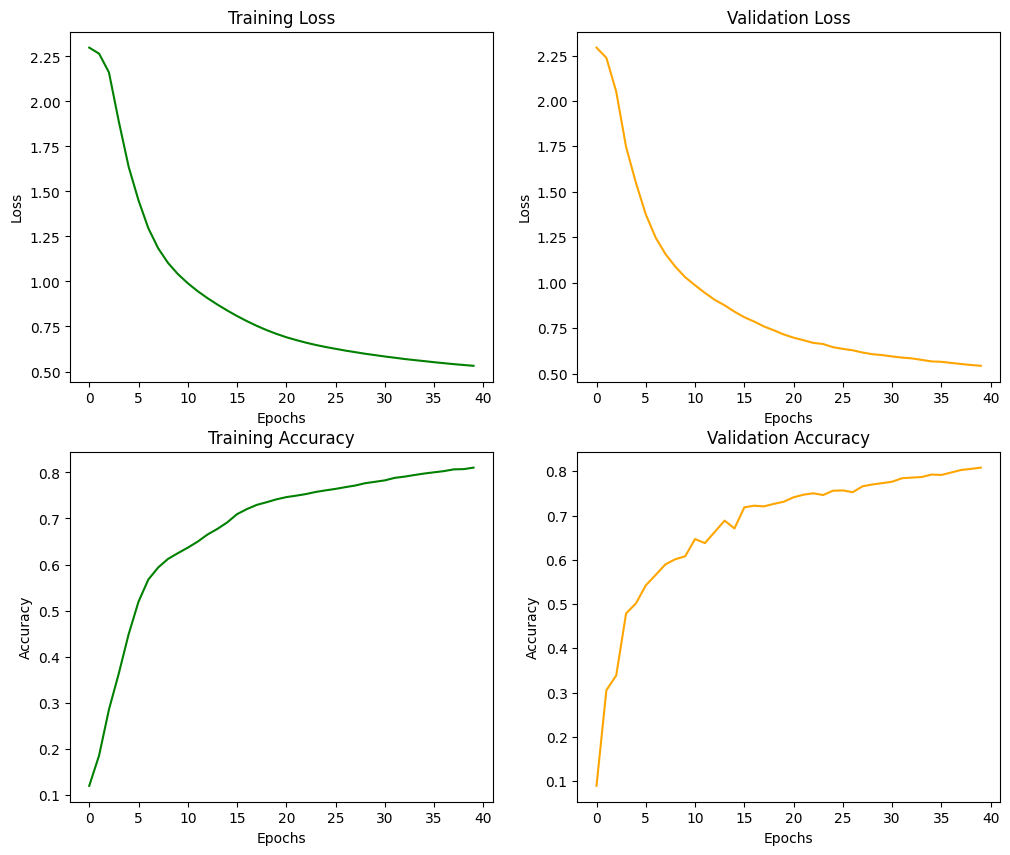

In [8]:
# 7. Trực quan hóa kết quả huấn luyện
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color = 'green')
ax[0, 0].set(xlabel='Epochs', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color = 'orange')
ax[0, 1].set(xlabel='Epochs', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color = 'green')
ax[1, 0].set(xlabel='Epochs', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color = 'orange')
ax[1, 1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

In [9]:
# 8. Đánh giá mô hình
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        outputs = model(X_test)

        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = (torch.argmax(test_predict, 1) == test_target).sum().item() / len(test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {test_acc}')


Evaluation on test set:
Accuracy: 0.8001
